**линейный классификатор**

Евгений Борисов <esborisov@sevsu.ru>

In [1]:
import numpy as np
from numpy import random  as rng
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(precision=2)

In [3]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

n_samples = 500
n_clst = 2 # количество классов

X,target = make_blobs( 
        n_samples=n_samples,
        centers=n_clst,  
        cluster_std=[1.5, 1.4,]
    )


X.shape, target.shape

((500, 2), (500,))

In [4]:
# prc = [10,25,50,75,95]
# np.percentile(X,prc,axis=0) 

In [5]:
# выход модели {0,1}
y = target[:,np.newaxis]

# нормируем данные
# from sklearn.preprocessing import MinMaxScaler
# X = MinMaxScaler([-1.0,1.0]).fit_transform(X)

from sklearn.preprocessing   import StandardScaler
X = StandardScaler().fit(X).transform(X)

X.shape, y.shape

((500, 2), (500, 1))

In [6]:
# докидываем свободный член
X = np.hstack([X,np.ones([X.shape[0],1])])
X.shape

(500, 3)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((250, 3), (250, 1), (250, 3), (250, 1))

In [8]:
del X
del y

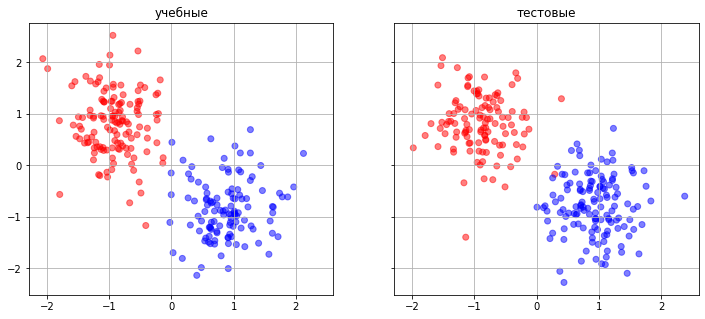

In [9]:
def plot_data(ax,X,y,t):
    c = [ ['b','r','g','y'][j] for j in y.flatten()  ]
    ax.set_title(t)
    ax.scatter( x=X[:,0], y=X[:,1], c=c,  alpha=0.5 )
    ax.grid()

fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_train,y_train,'учебные')    
plot_data(ax1,X_test,y_test,'тестовые')    
plt.show()

## модель

$$a(x,w) = sign\left(\sum\limits_{i=1} x_i \cdot w_i + w_0\right)$$

In [10]:
class Model:
    def __init(self):
        self._weight = 0.
    
    def _init_weight(self): pass
    def predict(self,x): return self._score(x) 
    def score(self,x): pass
    def _partial(self,x): pass
    
    @property
    def weight(self): return self._weight

    @weight.setter
    def weight(self, value): self._weight = value         

In [11]:
class LinearModel(Model):
    
    def __init__(self,input_size):
        super().__init__()
        self._init_weight(input_size)
        
    def _init_weight(self,input_size): 
        self._weight = rng.normal(size=input_size,scale=.01)
        return self

    def score(self,x): 
        return x.dot(self._weight)[:,np.newaxis]
    
    def _partial(self,x): 
        return x    

## функция потери

In [12]:
class Loss:
    
    def __init__(self,model):
        self._model = model
        self._history = []

    def estimate(self,x,target):
        s = self._estimate(self._model.score(x), target)
        self._history.append(s)
        return s
        
    def _estimate(self,output,target): pass    
    
    def gradient(self,x,target): 
        return self._gradient(x,target)
    
    def _gradient(self,x,target): pass

    def _norm(self,x):
        amax = np.abs(x).max()
        return x if amax==0. else x/amax

    @property
    def model(self): 
        return self._model

    @property
    def history(self): 
        return self._history

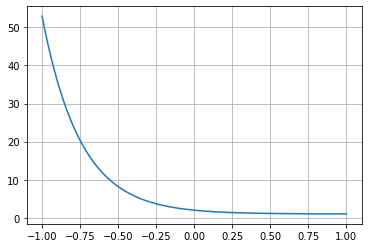

In [13]:
def loss_logistic(m,s=3.95): return 1. + np.exp(-s*m)
m = np.linspace(-1.,1.,100)
plt.plot(m,loss_logistic(m))
plt.grid()

$$
\mathscr{L}(m) = \log(1+\exp(-\sigma \cdot m))
$$

$$
\frac{\partial \mathscr{L}}{\partial m} = \frac{ -\sigma }{ 1+\exp(\sigma \cdot m) }
$$

$$
m = y - f(x,w)
$$

$$ 
\frac{\partial \mathscr{L}}{\partial w} 
= \frac{\partial  \mathscr{L}}{\partial m} \frac{\partial f}{\partial w}   
$$

In [14]:
class LogisticLoss(Loss):    

    def __init__(self,model,sigma):
        super().__init__(model=model)
        self._sigma = sigma

    def _estimate(self,output,target):
        margin = target - output
        s = 1. + np.exp( -self._sigma * margin )
        with np.errstate(divide='ignore',invalid='ignore',):
            r = np.where( s>0, np.log(s), 0. )
        return r.sum()/len(r)

    def _gradient(self,input_data,target):
        margin = target - self._model.score(input_data)
        dmargin = target - self._model._partial(input_data) 
        d = 1. + np.exp( self._sigma * margin ) # [:,np.newaxis]
        with np.errstate(divide='ignore',invalid='ignore',):
            g = np.where( d!=0, (-self._sigma/d)*dmargin, 0. )
        return self._norm( g.sum(axis=0)/len(g))

## метод коррекции параметров

$$ W := W-\alpha\frac{\partial \mathscr{L}}{\partial w}  $$

In [15]:
from tqdm import tqdm

class Optimimizer:
    
    def __init__(self,loss):
        self._loss = loss
               
    def fit(self,data,n_epoch=1): pass

In [16]:
class BaseGD(Optimimizer):

    def __init__(self,loss):
        super().__init__(loss=loss)

    def fit(self,data,lr, n_epoch=1,): 
        epoch = tqdm(range(n_epoch))
        for _ in epoch:
            self._fit_epoch(data,lr)
            self._estimate_epoch(data)
            epoch.set_postfix({'loss':self._loss.history[-1],} )
        return self._loss.model
    
    def _fit_epoch(self,data,lr): 
        self._adjust_weigth(data,lr) # обучаем модель
        return self

    def _adjust_weigth(self,data,lr):
        dw = self._weight_delta(data,lr)
        self._loss.model.weight  = self._loss.model.weight - dw
        return self
    
    def _weight_delta(self,data,lr):
        x,t = data
        d_loss = self._loss.gradient(x,t)
        return d_loss*lr

    def _estimate_epoch(self,data):
        self._loss.estimate(data[0],data[1])
        return self

In [17]:
class SGD(BaseGD):
    
    def __init__(self,loss):
        super().__init__(loss=loss)
        self._batch_size=0
    
    def _select_data(self,data,idx):
        return data[0][idx,:],data[1][idx,:]

    def _get_batch(self,data): 
        n_samples = data[1].shape[0] # количество учебных пар
        batch_count = np.ceil( n_samples/self._batch_size).astype(int) # количество батчей
        # перемешиваем учебный набор и режем его на батчи
        for idx in np.array_split(rng.permutation(n_samples), batch_count ):
            yield self._select_data(data,idx) 

    def _fit_epoch(self,data,lr): 
        for batch_data in self._get_batch(data):
            super()._fit_epoch( batch_data,lr) # обучаем модель на батче
        return self
  
    def fit(self, data, batch_size, lr, n_epoch=1, ):
        self._batch_size=batch_size
        return super().fit(data,lr,n_epoch)


## создаём и обучаем модель

In [18]:
model = LinearModel(input_size=X_train.shape[1])
# model.score(X_train)
# model.predict(X_train)
# model._partial(X_train)

In [19]:
loss = LogisticLoss(model,sigma=4.95)
# loss.estimate(X_train,y_train)
# loss.gradient(X_train,y_train)

100%|██████████| 10/10 [00:00<00:00, 317.75it/s, loss=0.0191]


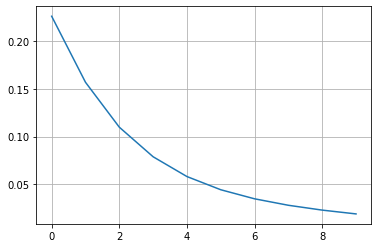

In [20]:
# model = BaseGD(loss).fit([X_train,y_train],lr=.01, n_epoch=50,)
model = SGD(loss).fit([X_train,y_train],batch_size=len(y_train)//3,lr=.01, n_epoch=10,)

plt.plot(loss.history)
plt.grid()

## тестируем модель

In [21]:
s = model.score(X_test)

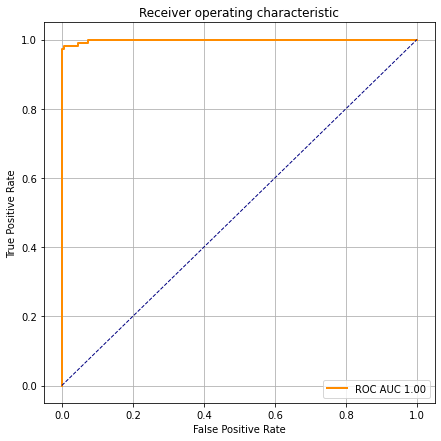

In [22]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve( y_test, s )
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
plt.grid(True)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC AUC %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [23]:
# оптимальный порого скора 
#  максимальное количество True Positive при минимальном количестве False Positive
optimal_threshold = thresholds[ np.argmax( np.abs(tpr-fpr) )  ]
optimal_threshold

-0.4100251318015761

In [24]:
p = (s>optimal_threshold).astype(int)
y = (y_test>0).astype(int)

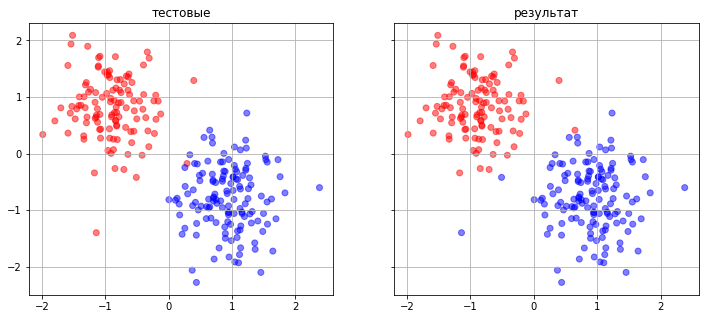

In [25]:
fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_test,y,'тестовые')    
plot_data(ax1,X_test,p,'результат')    
plt.show()

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y,p))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       134
           1       0.99      0.97      0.98       116

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250

